In [1]:
import configparser

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.special import boxcox, inv_boxcox
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

In [2]:
# From: https://www.kaggle.com/datasets/vetrirah/ml-iot/?select=train_ML_IOT.csv
df = pd.read_csv("datasets/train_ML_IOT.csv", parse_dates=['DateTime'], index_col='DateTime')
df = df[df["Junction"] == 1].drop(["Junction", "ID"], axis=1)

In [3]:
df

,Vehicles
DateTime,
2015-11-01 00:00:00,15
2015-11-01 01:00:00,13
2015-11-01 02:00:00,10
2015-11-01 03:00:00,7
2015-11-01 04:00:00,9
...,...
2017-06-30 19:00:00,105
2017-06-30 20:00:00,96
2017-06-30 21:00:00,90


In [4]:
df.Vehicles

DateTime
2015-11-01 00:00:00     15
2015-11-01 01:00:00     13
2015-11-01 02:00:00     10
2015-11-01 03:00:00      7
2015-11-01 04:00:00      9
                      ... 
2017-06-30 19:00:00    105
2017-06-30 20:00:00     96
2017-06-30 21:00:00     90
2017-06-30 22:00:00     84
2017-06-30 23:00:00     78
Name: Vehicles, Length: 14592, dtype: int64

In [5]:
def test_stationary(row, lag=60):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
    row.plot(ax=ax[0])
    plot_acf(row, lags=lag, ax=ax[1])
    p_value = adfuller(row)[1]
    print(
        f'Fuller p-value = {round(p_value, 4)}. Ряд {"не стационарен" if p_value > 0.05 else "стационарен"}.')

## Проверим исходный ряд на стационарность

Fuller p-value = 0.0. Ряд стационарен.


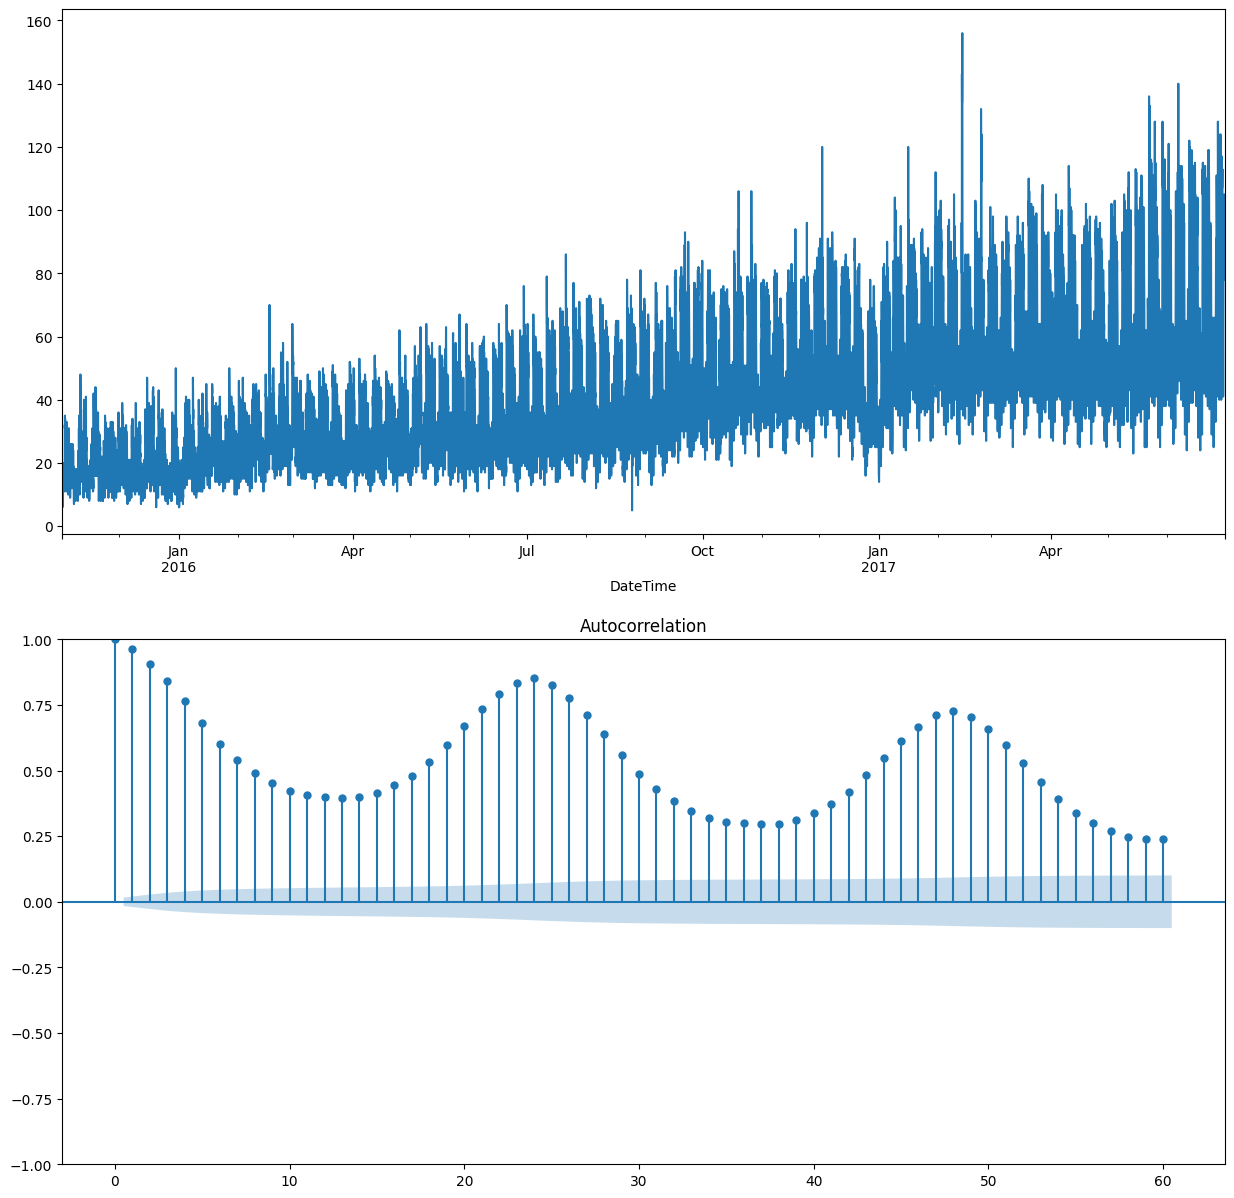

In [6]:
test_stationary(df.Vehicles, lag=60)

Очевидно есть некая сезонность в 24 часа

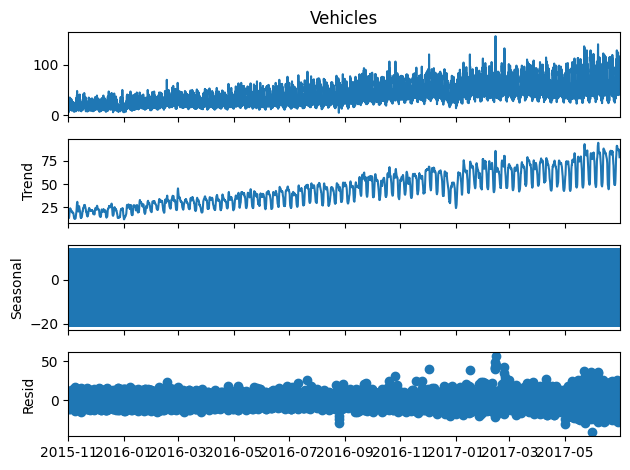

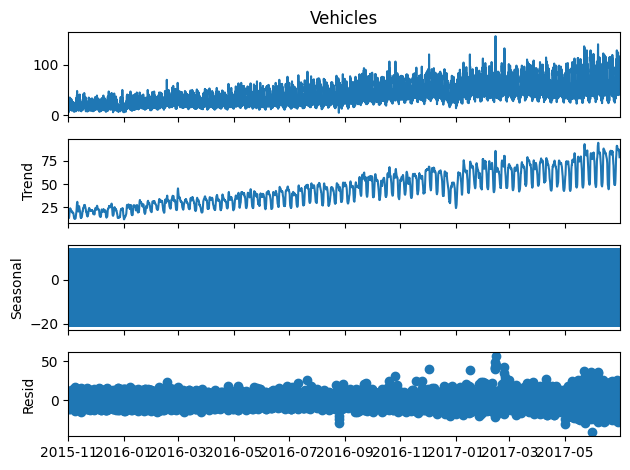

In [7]:
result = seasonal_decompose(df.Vehicles, period=24)
result.plot()

<Axes: xlabel='DateTime'>

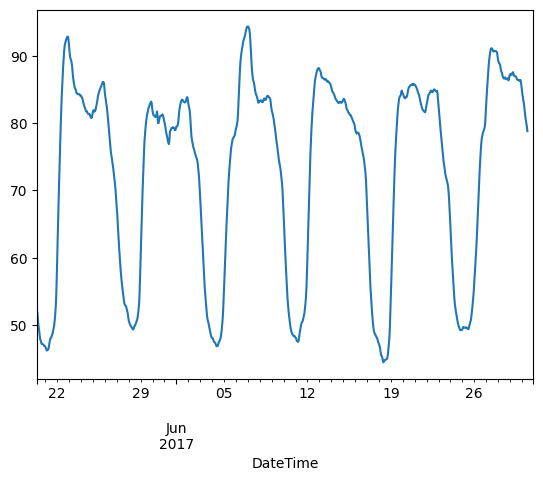

In [8]:
seasonal_decompose(df, period=24).trend[-1000:].plot()

Не пойдёт... У нас тут ещё один период всплыл, на этот раз недельный. Давайте перейдём от часового периода на среднесуточный!

<Axes: xlabel='DateTime'>

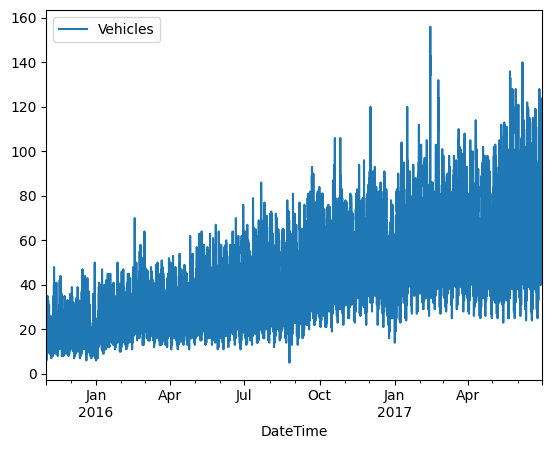

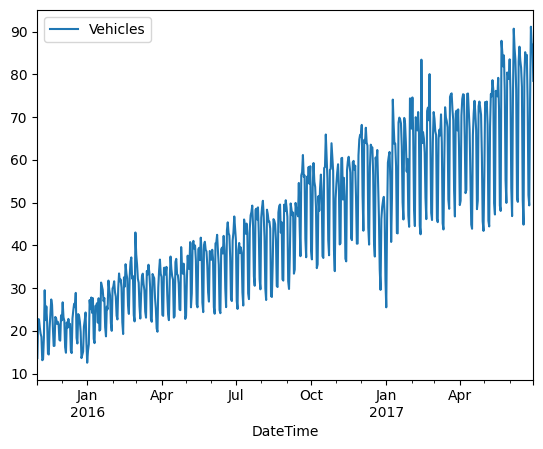

In [9]:
df.plot()
df = df.resample('D').mean()
df.plot()

<Axes: xlabel='DateTime'>

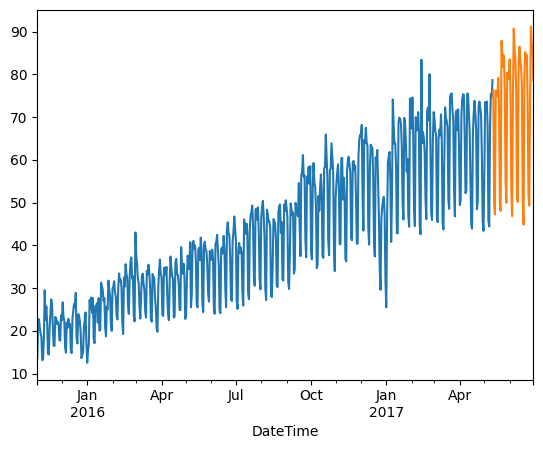

In [10]:
train_df = df[:-50]
test_df = df[-50:]

train_df.Vehicles.plot()
test_df.Vehicles.plot()

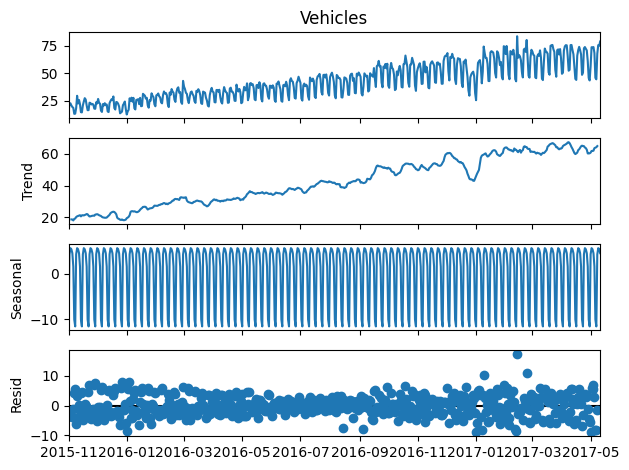

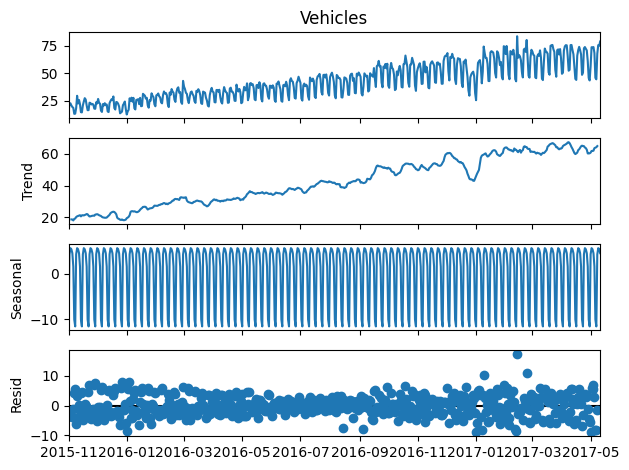

In [11]:
seasonal_decompose(train_df.Vehicles, period=7).plot()

Ну хорошо, с этим уже можно работать

## Преобразуем

Сделаем универсальный трансформер

In [12]:
def diff(row, period, start=0):
    return row.diff(period)[period:], (
        row[start:start + period] if start + period != 0 else row[start:])


def undiff(row, base):  # len(base) must be equal to diff(x) parameter
    padding = len(base)
    result = pd.concat([base, row])
    for i in range(padding, len(result), padding):
        result = result.add(result[i - padding: i + padding].shift(padding), fill_value=0.0)
    return result

<Axes: xlabel='DateTime'>

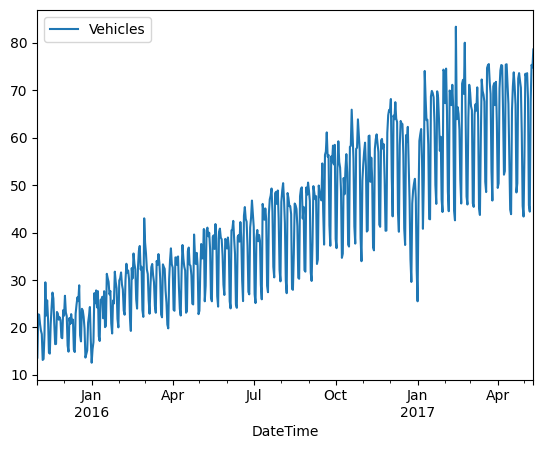

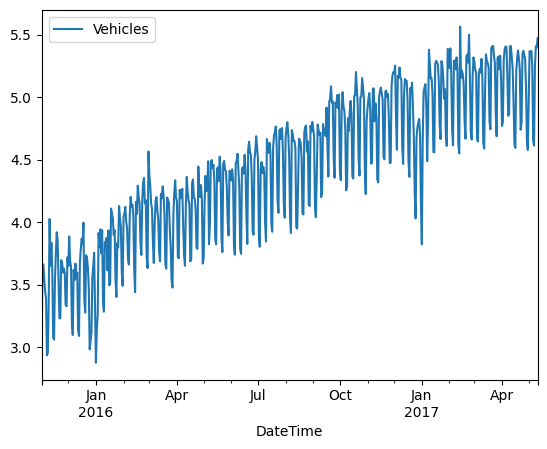

In [13]:
train_df.plot()
train_df_cox = boxcox(train_df, 0.1)
train_df_cox.plot()

<Axes: xlabel='DateTime'>

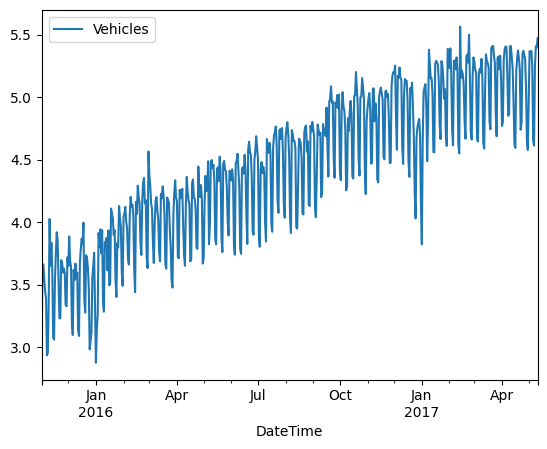

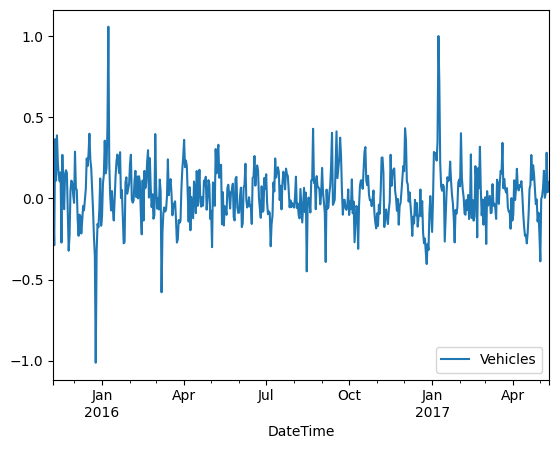

In [14]:
train_df_cox_diff, train_df_diff_base = diff(train_df_cox, 7)
train_df_cox.plot()
train_df_cox_diff.plot()

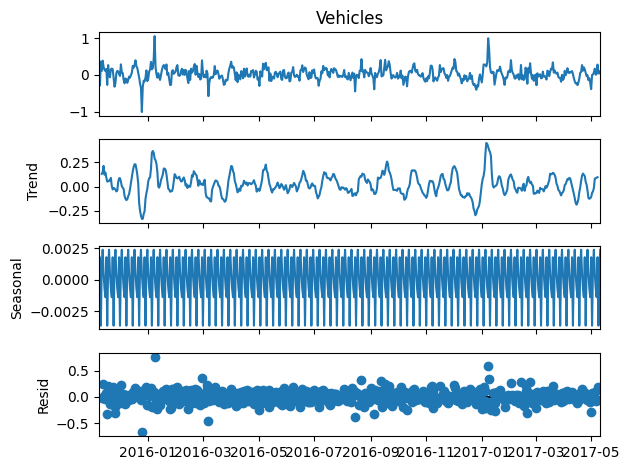

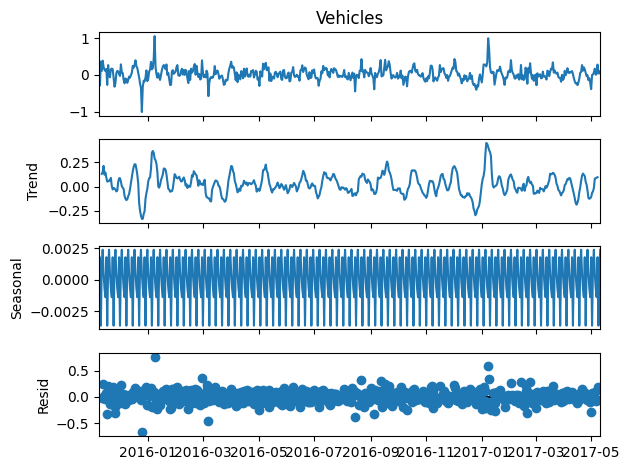

In [15]:
result = seasonal_decompose(train_df_cox_diff.Vehicles, period=7)
result.plot()

<Axes: xlabel='DateTime'>

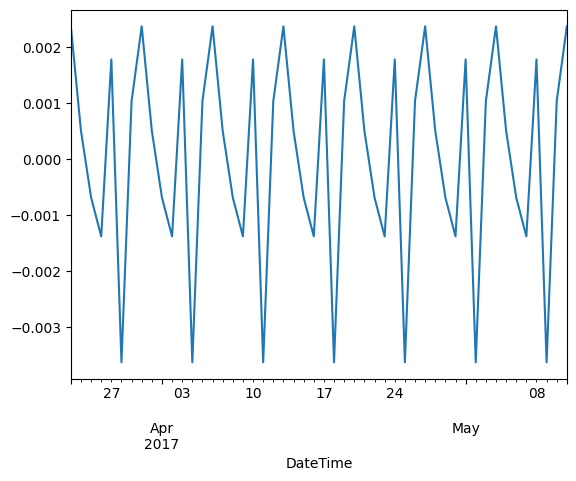

In [16]:
result.seasonal[-50:].plot()

Выглядит красиво, осталось проверить на стационарность:

Fuller p-value = 0.0. Ряд стационарен.


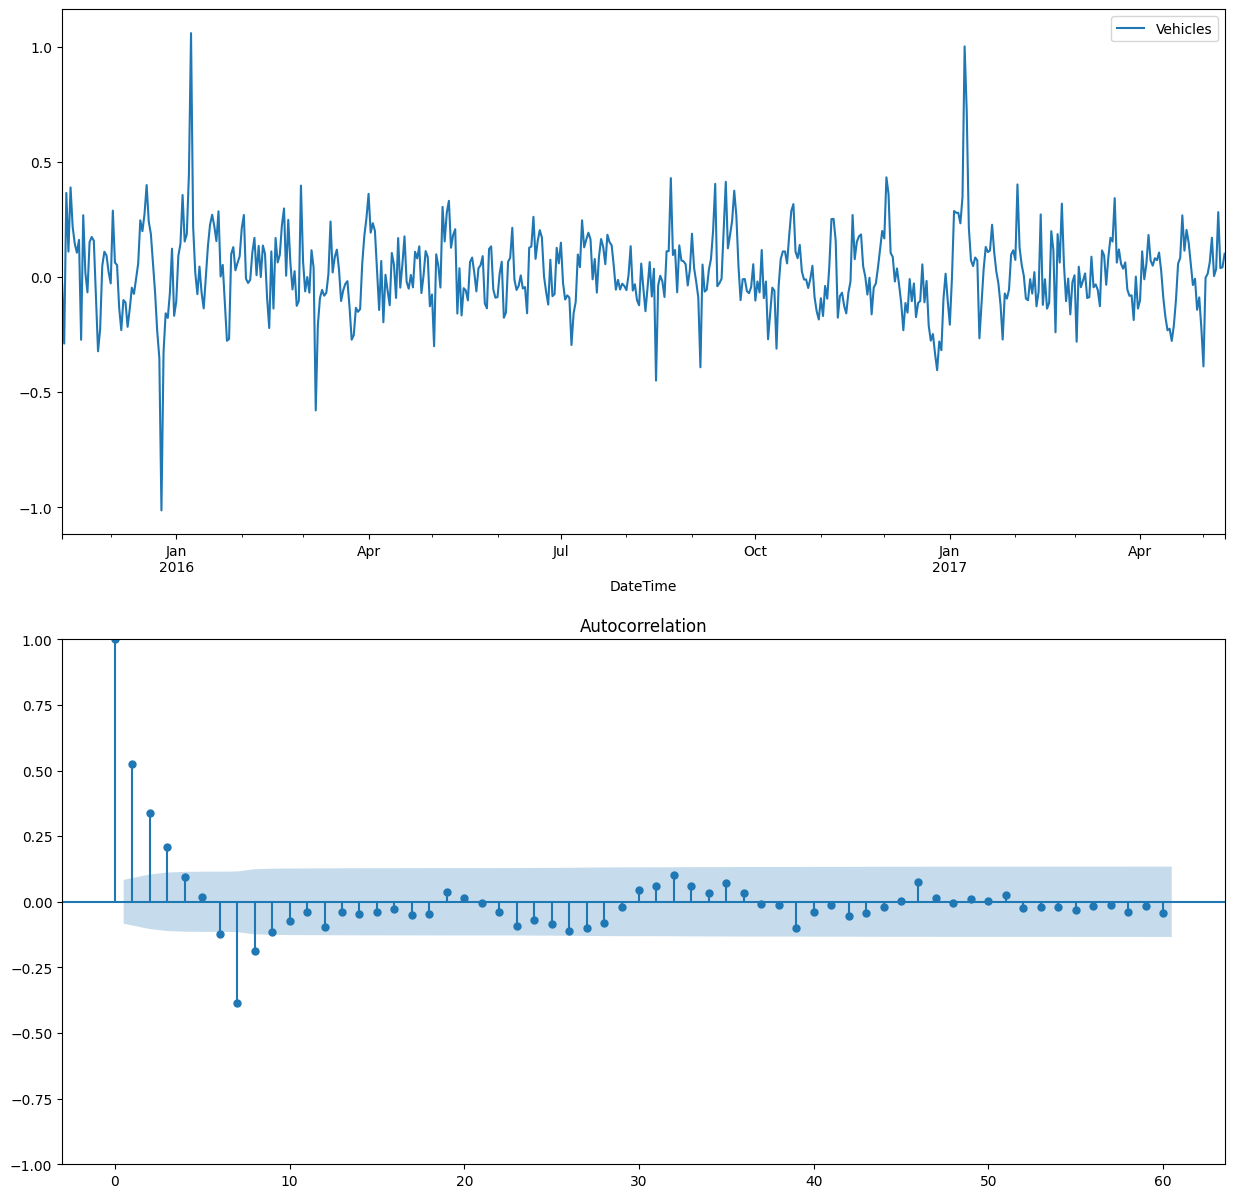

In [17]:
test_stationary(train_df_cox_diff)

# SARIMA (готовая)

In [18]:
sarima = SARIMAX(train_df_cox, order=(1, 0, 1), seasonal_order=(1, 0, 1, 7), )
model = sarima.fit(method='bfgs')

C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


         Current function value: -0.707071
         Iterations: 50
         Function evaluations: 66
         Gradient evaluations: 66


C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                          Vehicles   No. Observations:                  558
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood                 394.546
Date:                           Wed, 25 Oct 2023   AIC                           -779.092
Time:                                   05:09:08   BIC                           -757.470
Sample:                               11-01-2015   HQIC                          -770.648
                                    - 05-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9980      0.002    508.997      0.000       0.994       1.002
ma.L1         -0.4935      0.026    -18.790      0.000      -0.545      -0.442
ar.S.L7        0.9997      0.000   4255.187      0.000       0.999       1.000
ma.S.L7       -0.9367      0.019    -49.788      0.000      -0.974      -0.900
sigma2         0.0132      0.001     23.001      0.000       0.012       0.014
===================================================================================
Ljung-Box (L1) (Q):                   3.48   Jarque-Bera (JB):               123.14
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               0.62   Skew:                             0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='DateTime'>

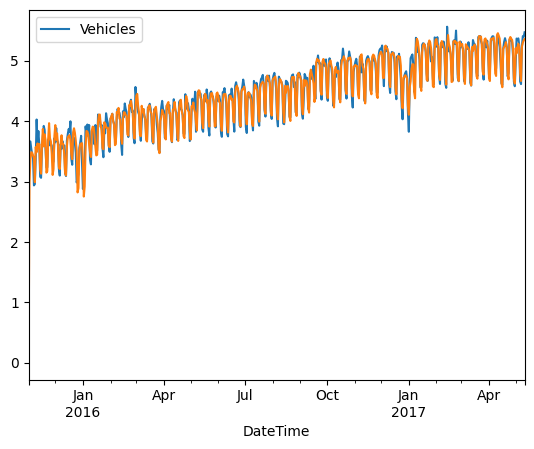

In [20]:
train_df_cox.plot()
model.predict().plot()

In [21]:
fitted = model.forecast(50)

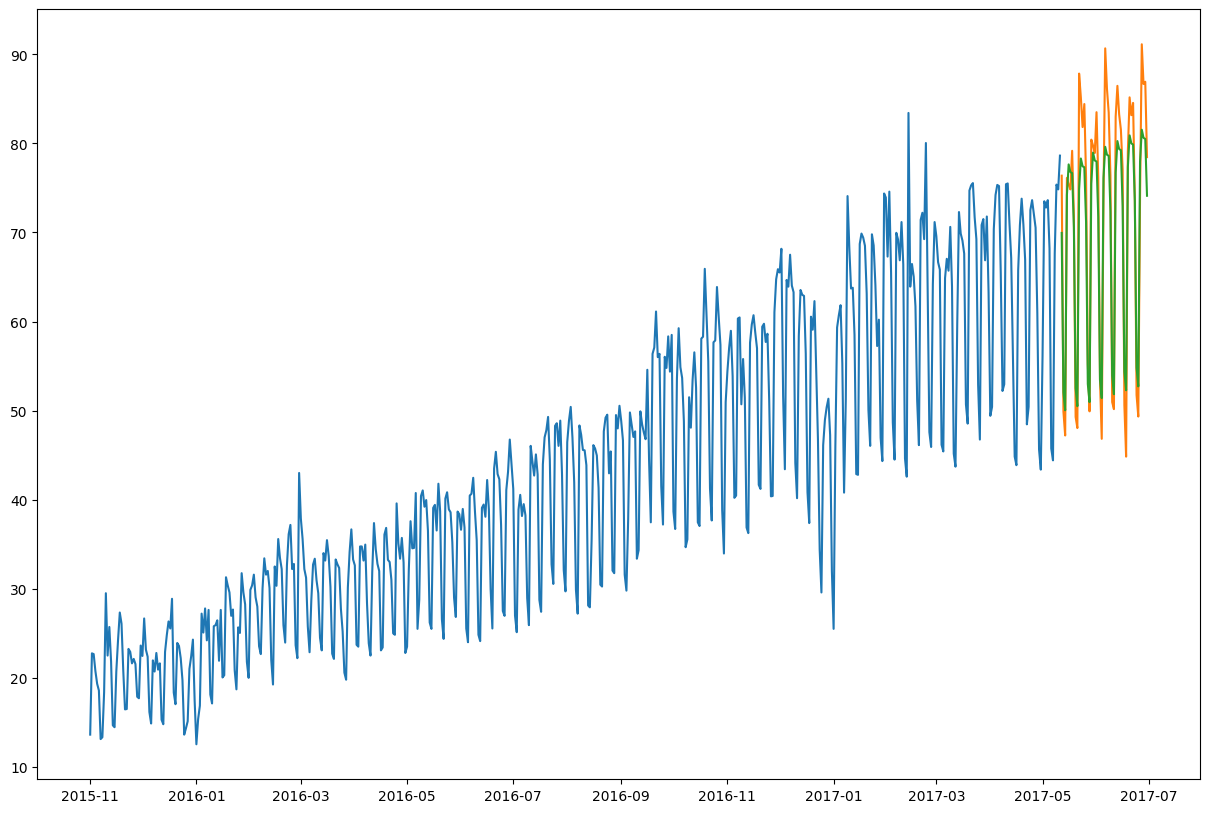

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(train_df)
plt.plot(test_df)
plt.plot(inv_boxcox(pd.Series(fitted), 0.1))

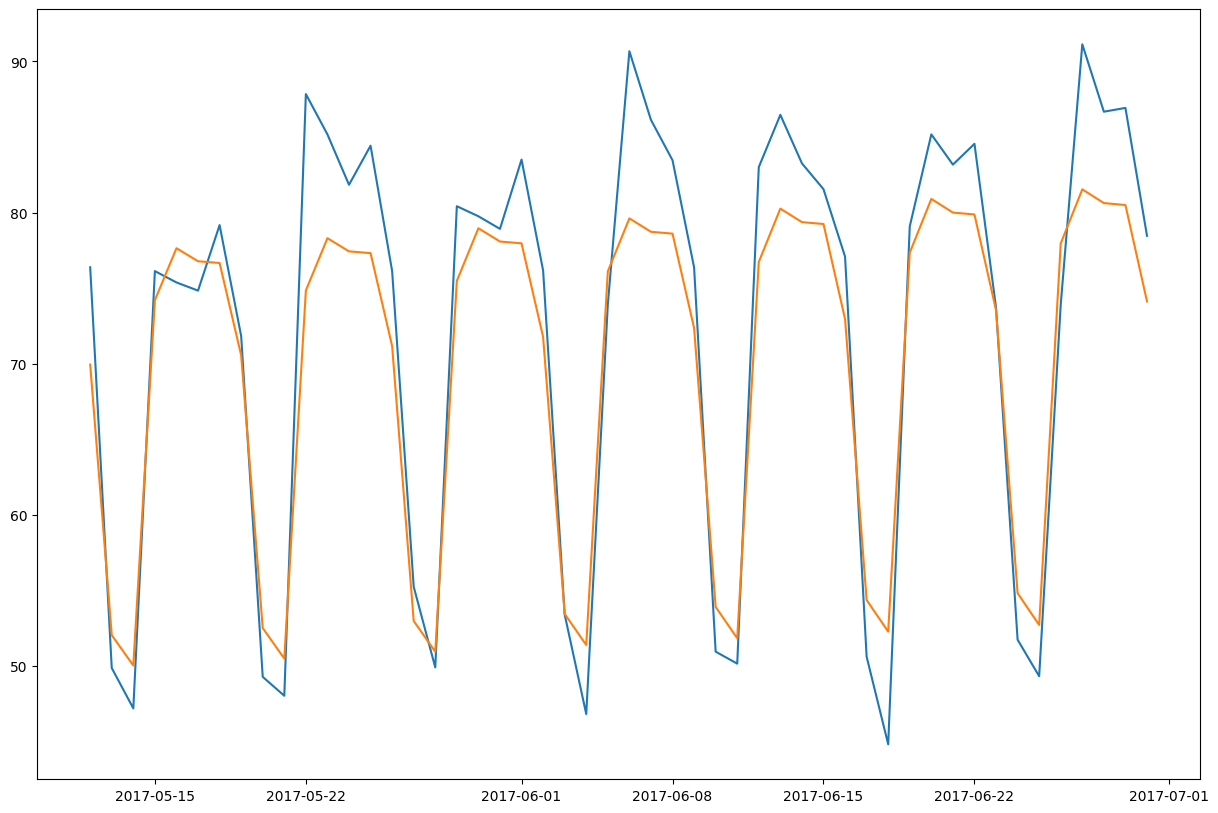

In [23]:
plt.figure(figsize=(15, 10))
# plt.plot(train_df)
plt.plot(test_df)
plt.plot(inv_boxcox(pd.Series(fitted), 0.1))

# Собственная реализация

In [24]:
def get_features(data, lags, step=1):
    features = pd.DataFrame()

    for i in range(1, lags + 1):
        features[f'{i}'] = data.shift(i * step)

    return features.dropna()

In [25]:
def optimize(features, res):
    mat = pd.concat([features, res], axis=1)
    mat = mat.dropna()
    res = mat.iloc[:, -1:]
    coeff = mat.iloc[:, :-1]
    return (np.linalg.inv(coeff.T @ coeff) @ coeff.T @ res).to_numpy()

In [26]:
class AR:
    def __init__(self, P, dataset, step=1):
        self.P = P
        self.step = step
        self.dataset = dataset
        self.features = get_features(dataset, P, step)
        self.weights = optimize(self.features, dataset)
        self.resid = dataset.shift(P * step).dropna().values - (self.features @ self.weights)
        self.ds_last_part = dataset[::-1][(step - 1):(step - 1) + step * P].values

    def predict(self, n=35):
        result = []
        weights = self.weights
        ds_last_part = self.ds_last_part.reshape(-1)

        for x in range(n):
            prediction = weights.reshape(-1) @ ds_last_part[::self.step]
            prediction = prediction
            result.append(prediction)
            ds_last_part = ds_last_part[:-1]
            ds_last_part = np.append(result[x], ds_last_part)
        index = pd.date_range(self.dataset.index[-1] + self.dataset.index.freq, periods=n,
                              freq=self.dataset.index.freq)
        return pd.Series(result, index=index).to_frame(self.dataset.columns[0])

In [27]:
class MA:
    def __init__(self, Q, ar, step=1):
        resid = ar.resid
        self.dataset = ar.dataset
        self.features = get_features(resid, Q, step)
        self.weights = optimize(self.features, resid)
        self.rs_last_part = resid[::-1][step:step * (Q + 1)].values
        self.Q = Q
        self.step = step

    def predict(self, n=35):
        result = []
        weights = self.weights
        rs_last_part = self.rs_last_part.reshape(-1)

        for x in range(n):
            prediction = weights.reshape(-1) @ rs_last_part[::self.step]
            prediction = prediction
            result.append(prediction)
            rs_last_part = rs_last_part[:-1]
            rs_last_part = np.append(np.array(0.), rs_last_part)
        index = pd.date_range(self.dataset.index[-1] + self.dataset.index.freq, periods=n,
                              freq=self.dataset.index.freq)
        return pd.Series(result, index=index).to_frame(self.dataset.columns[0])

In [28]:
class SARIMA:
    def __init__(self, P, Q, D, SP, SQ, SD, S, dataset):
        self.s_diff_base = []
        for _ in range(SD):
            dataset, base = diff(dataset, S, -S - 1)
            self.s_diff_base.append(base)

        self.diff_base = []
        for _ in range(D):
            dataset, base = diff(dataset, 1, -1)
            self.diff_base.append(base)

        self.ar = AR(P, dataset)
        self.sar = AR(SP, dataset, S)
        self.ma = MA(Q, self.ar)
        self.sma = MA(SQ, self.sar, S)

        ar_features = self.ar.features
        sar_features = self.sar.features

        self.sar_features = pd.concat([ar_features, sar_features], axis=1)
        self.sar_features = self.sar_features.dropna()

        self.sar_weights = optimize(self.sar_features, dataset)

        ar_weights = self.sar_weights[:P]
        sar_weights = self.sar_weights[P: P + SP]
        self.ar.weights = ar_weights
        self.sar.weights = sar_weights

        self.P = P
        self.Q = Q
        self.SP = SP
        self.SQ = SQ
        self.S = S

    def predict(self, n=35):
        predictions = self.ar.predict(n)
        predictions += self.ma.predict(n)
        predictions += self.sar.predict(n)
        predictions += self.sma.predict(n)

        to_cut = 0
        for x in self.diff_base[::-1]:
            predictions = undiff(predictions, x)
            to_cut += 1

        for x in self.s_diff_base[::-1]:
            predictions = undiff(predictions, x)
            to_cut += self.S
        predictions = predictions[to_cut:]

        return predictions


# Применение

In [29]:
config = configparser.ConfigParser()
config.read('config.ini')
ar_lags = int(config['SARIMA']['ar_lags'])
diffs = int(config['SARIMA']['diffs'])
ma_lags = int(config['SARIMA']['ma_lags'])
s_ar_lags = int(config['SARIMA']['s_ar_lags'])
s_diffs = int(config['SARIMA']['s_diffs'])
s_ma_lags = int(config['SARIMA']['s_ma_lags'])
seasonality = int(config['SARIMA']['seasonality'])

In [30]:
my_sarima = SARIMA(ar_lags, ma_lags, diffs, s_ar_lags, s_ma_lags, s_diffs, seasonality,
                   train_df_cox[-25:])

In [31]:
sarima = SARIMAX(train_df_cox[-25:], order=(ar_lags, diffs, ma_lags),
                 seasonal_order=(s_ar_lags, s_diffs, s_ma_lags, seasonality), )
model = sarima.fit(method='bfgs')

C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


         Current function value: -0.504685
         Iterations: 50
         Function evaluations: 64
         Gradient evaluations: 64


C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_optimize.py:1360: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
C:\Users\btima\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


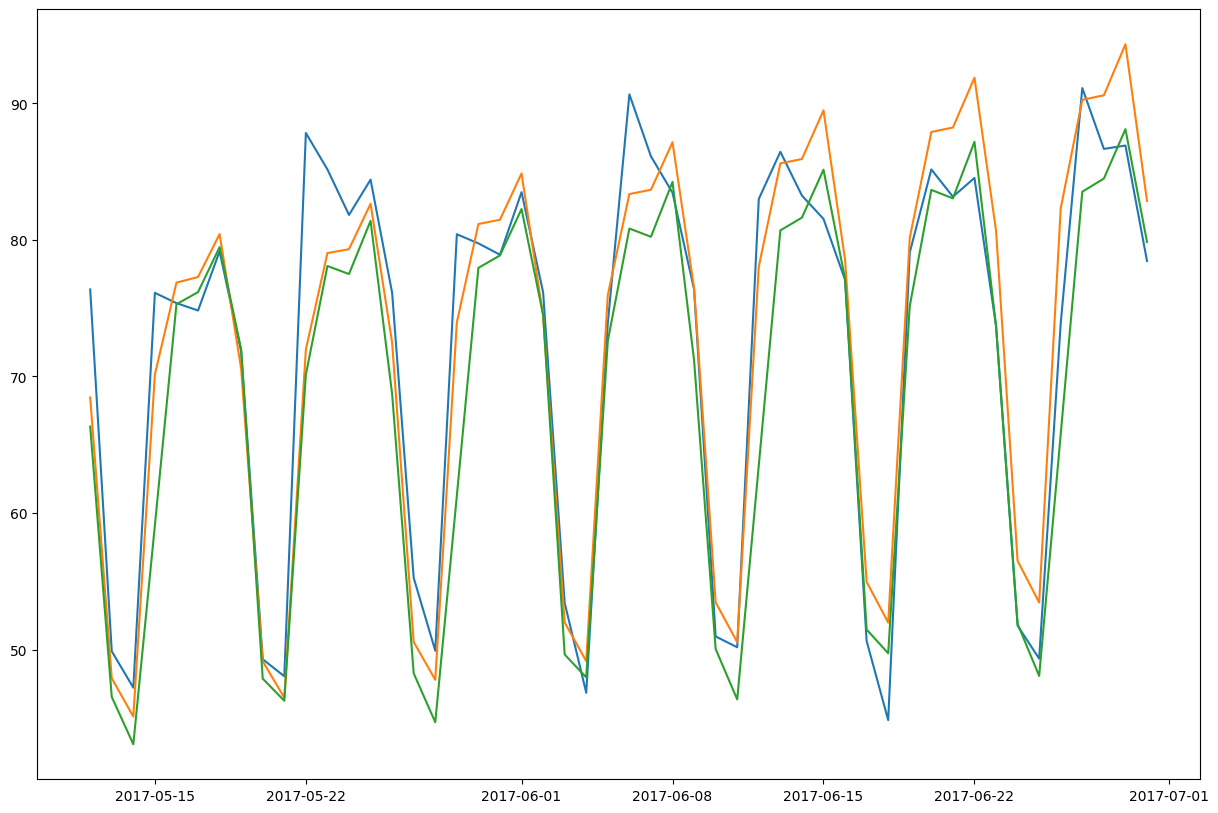

In [32]:
plt.figure(figsize=(15, 10))
plt.plot(test_df)

fitted_orig = model.forecast(50)

fitted_my = my_sarima.predict(50)
plt.plot(inv_boxcox(fitted_my, 0.1))

plt.plot(inv_boxcox(fitted_orig, 0.1))

In [33]:
mean_absolute_percentage_error(fitted_my, test_df)

12.46139580951013

In [34]:
mean_absolute_percentage_error(fitted_orig, test_df)

12.683121615806062